# PML Playground

This notebook is for **testing and tuning the PML (Perfectly Matched Layer)** 
for the Helmholtz operator in the `FreqTransfer` project.

Goals:

1. Compare solutions **with and without PML**.
2. Vary `thickness`, `m`, and `sigma_max` in `PMLConfig`.
3. Inspect:
   - Field magnitude plots `|u(x)|`
   - GMRES residual histories


In [13]:
import sys, os

# Go one directory up from the notebooks folder
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Using project root:", PROJECT_ROOT)
print("Contents:", os.listdir(PROJECT_ROOT))  # should show 'src', 'notebooks', ...


Using project root: c:\Users\31624\Documents\MIT\Programming\FreqTransfer
Contents: ['.git', '.gitignore', '.venv', 'data', 'notebooks', 'README.md', 'requirements.txt', 'src', 'tests']


In [14]:
from src import (
    GridSpec, PMLConfig, FDConfig, SolverOptions,
    assemble_operator,
    plot_field, plot_residuals,
    RandomPointSource, build_load,
    gmres_solve, direct_solve,
)


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(0)

# Nicely sized plots
plt.rcParams["figure.figsize"] = (5, 4)

print("Imports OK.")


Imports OK.


## 1. Define grid, wavenumber, and RHS

We set up:
- A 2D square grid
- A fixed wavenumber `k`
- A single **random point source** as the right-hand side.


In [16]:
# Grid definition
grid = GridSpec(
    dims=2,
    shape=(48, 48),   # (Ny, Nx)
    lengths=(1.0, 1.0)
)

# Wavenumber (make sure it's a float, not a string)
k = float(30.0)

# Solver options for GMRES
solver_opts = SolverOptions(tol=1e-6, restart=200, maxiter=None)

# --- Build a single randomized point-source RHS ---
seed_rhs = 123
rhs_spec = RandomPointSource(seed=seed_rhs)
b = build_load(rhs_spec, grid)  # flattened complex RHS

print("Grid:", grid)
print("k =", k)
print("RHS shape:", b.shape)


Grid: GridSpec(dims=2, shape=(48, 48), lengths=(1.0, 1.0))
k = 30.0
RHS shape: (2304,)


## 2. Solve *without* PML (reference solution)

This is our baseline:
- Standard Helmholtz operator
- No absorbing layer
- We use a **direct solve** for a clean reference.


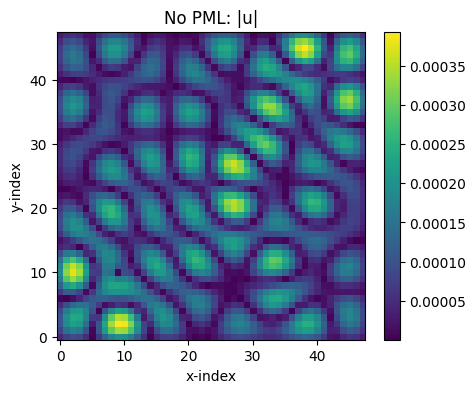

In [17]:
# Assemble operator without PML
A_no = assemble_operator(grid=grid, k=k, kind="helmholtz", pml=None)

# Direct solve for reference
res_no = direct_solve(A_no, b)
u_no = res_no.solution.reshape(grid.shape)

# Plot magnitude |u|
ax = plot_field(u_no, grid.shape, which="magnitude")
ax.set_title("No PML: |u|")
plt.show()


## 3. Solve *with* default PML settings

We now use:
```python
PMLConfig(thickness=8, m=3, sigma_max=50.0)


GMRES converged: True | iterations: 36452


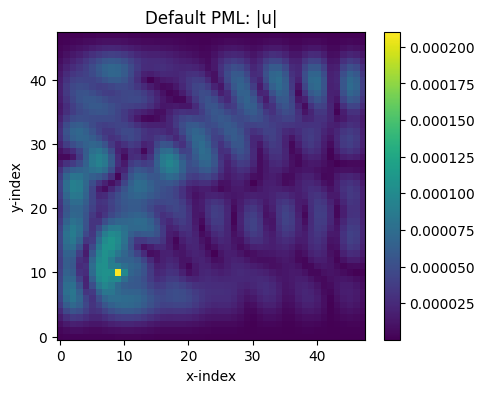

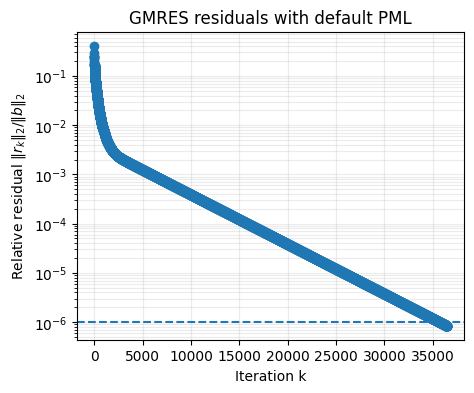

In [19]:
### 🟡 Cell 8 — *Python*: default PML solve

# Default PML configuration
pml_default = PMLConfig()  # thickness=8, m=3, sigma_max=50.0

# Assemble with PML
A_pml = assemble_operator(grid=grid, k=k, kind="helmholtz", pml=pml_default)

# Solve with GMRES so we also see residual history
res_pml = gmres_solve(A_pml, b, options=solver_opts)
u_pml = res_pml.solution.reshape(grid.shape)

print("GMRES converged:", res_pml.converged, "| iterations:", len(res_pml.residuals))

# Plot |u| with PML
ax = plot_field(u_pml, grid.shape, which="magnitude")
ax.set_title("Default PML: |u|")
plt.show()

# Compare GMRES residuals
ax = plot_residuals(res_pml, tol=solver_opts.tol)
ax.set_title("GMRES residuals with default PML")
plt.show()


## 4. Visual comparison: no PML vs PML

Side-by-side plots of `|u|` to see how the PML affects:

- Interior amplitude
- Boundary decay
- Possible over-damping


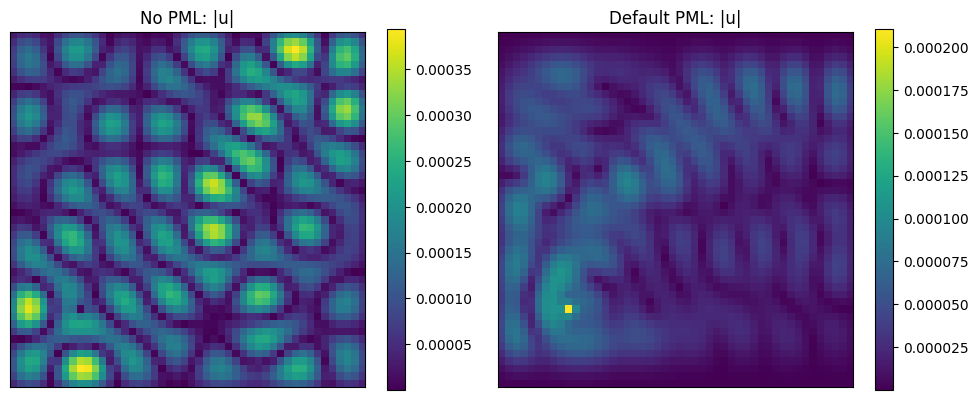

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plt.sca(axes[0])
im0 = axes[0].imshow(np.abs(u_no), origin="lower")
axes[0].set_title("No PML: |u|")
plt.colorbar(im0, ax=axes[0])

plt.sca(axes[1])
im1 = axes[1].imshow(np.abs(u_pml), origin="lower")
axes[1].set_title("Default PML: |u|")
plt.colorbar(im1, ax=axes[1])

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


## 5. Sweep over PML parameters

We now try a few different `PMLConfig` choices:

- Vary `sigma_max` (strength of absorption)
- Vary `thickness` (width of absorbing layer)

We keep the RHS and `k` fixed and solve with GMRES.



=== no PML ===
  converged: True | iterations: 8366

=== thin, weak ===
  converged: True | iterations: 11382

=== default ===
  converged: True | iterations: 36452

=== thick, med ===
  converged: True | iterations: 11208


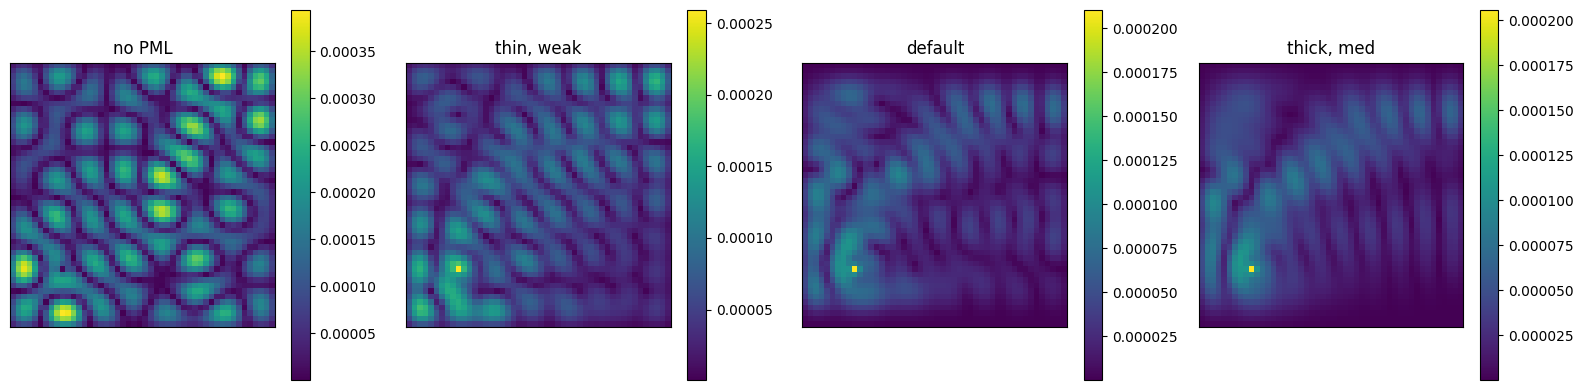

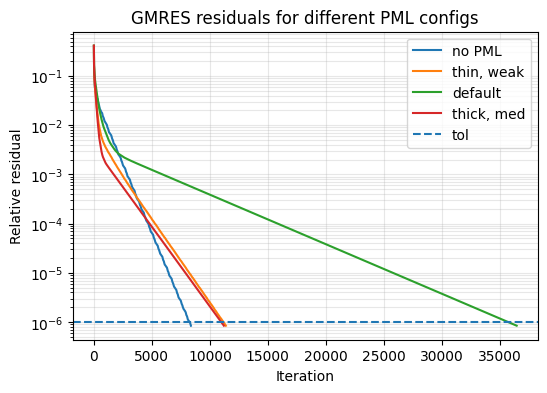

In [21]:
pml_configs = [
    ("no PML",     None),
    ("thin, weak", PMLConfig(thickness=4,  m=3, sigma_max=10.0)),
    ("default",    PMLConfig(thickness=8,  m=3, sigma_max=50.0)),
    ("thick, med", PMLConfig(thickness=12, m=3, sigma_max=20.0)),
]

solutions = {}
residuals = {}

for name, pml in pml_configs:
    print(f"\n=== {name} ===")
    A = assemble_operator(grid=grid, k=k, kind="helmholtz", pml=pml)
    res = gmres_solve(A, b, options=solver_opts)
    u = res.solution.reshape(grid.shape)

    solutions[name] = u
    residuals[name] = res.residuals

    print("  converged:", res.converged, "| iterations:", len(res.residuals))

# Plot magnitude for all configs
n = len(pml_configs)
fig, axes = plt.subplots(1, n, figsize=(4*n, 4))

for ax, (name, _) in zip(axes, pml_configs):
    u = solutions[name]
    im = ax.imshow(np.abs(u), origin="lower")
    ax.set_title(name)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

# Plot residuals on one figure (log-scale)
plt.figure(figsize=(6, 4))
for name in residuals:
    if len(residuals[name]) > 0:
        plt.semilogy(residuals[name], label=name)
plt.axhline(solver_opts.tol, linestyle="--", label="tol")
plt.xlabel("Iteration")
plt.ylabel("Relative residual")
plt.legend()
plt.title("GMRES residuals for different PML configs")
plt.grid(True, which="both", alpha=0.3)
plt.show()


DIRECT

In [22]:
import numpy as np
from src import (
    GridSpec, PMLConfig,
    assemble_operator,
    RandomPointSource, build_load,
    direct_solve,
)

# ---------------------------------------------------------
# 1. Problem setup
# ---------------------------------------------------------
# Grid and wavenumber
grid = GridSpec(dims=2, shape=(48, 48), lengths=(1.0, 1.0))
k = float(30.0)

# Single RHS (fix seed so comparisons are fair)
rhs_seed = 123
rhs_spec = RandomPointSource(seed=rhs_seed)
b = build_load(rhs_spec, grid)   # flattened complex RHS

print("Grid:", grid, "| k =", k, "| RHS shape =", b.shape)


# ---------------------------------------------------------
# 2. Helper: build interior / boundary-band masks
# ---------------------------------------------------------
def pml_band_and_interior_masks(shape, thickness):
    """
    Returns two boolean masks (mask_interior, mask_band).

    mask_band: cells within 'thickness' of any boundary
    mask_interior: complement of mask_band
    """
    ny, nx = shape
    band = np.zeros(shape, dtype=bool)

    # top / bottom
    band[:thickness, :] = True
    band[-thickness:, :] = True
    # left / right
    band[:, :thickness] = True
    band[:, -thickness:] = True

    interior = ~band
    return interior, band


# ---------------------------------------------------------
# 3. Reference solution: no PML (direct solve)
# ---------------------------------------------------------
A_ref = assemble_operator(grid=grid, k=k, kind="helmholtz", pml=None)
res_ref = direct_solve(A_ref, b)
u_ref = res_ref.solution.reshape(grid.shape)

# interior defined by some baseline band (e.g. 8 cells from boundary)
baseline_thickness = 8
mask_int_ref, _ = pml_band_and_interior_masks(grid.shape, baseline_thickness)

int_norm_ref = np.linalg.norm(u_ref[mask_int_ref])
print(f"Reference interior L2 norm (no PML) = {int_norm_ref:.3e}")


# ---------------------------------------------------------
# 4. PML tuning sweep using *direct* solves
# ---------------------------------------------------------
thickness_list = [6, 10, 14]        # cells
sigma_list     = [10.0, 20.0, 30.0] # sigma_max values
order_list     = [2, 3]             # polynomial order m

tuning_results = []

for th in thickness_list:
    # masks for this thickness
    mask_int, mask_band = pml_band_and_interior_masks(grid.shape, th)

    for sig in sigma_list:
        for n in order_list:
            pml_cfg = PMLConfig(thickness=th, m=n, sigma_max=sig)

            # Assemble + direct solve with this PML
            A_pml = assemble_operator(grid=grid, k=k, kind="helmholtz", pml=pml_cfg)
            res_pml = direct_solve(A_pml, b)
            u_pml = res_pml.solution.reshape(grid.shape)

            # Interior & band norms
            int_norm = np.linalg.norm(u_pml[mask_int])
            band_norm = np.linalg.norm(u_pml[mask_band])

            # Metrics
            band_ratio = band_norm / (int_norm + 1e-15)  # want this small
            interior_loss = abs(int_norm - int_norm_ref) / (int_norm_ref + 1e-15)

            tuning_results.append({
                "thickness": th,
                "sigma_max": sig,
                "order": n,
                "interior_norm": int_norm,
                "band_norm": band_norm,
                "band_ratio": band_ratio,
                "interior_loss": interior_loss,
            })

# ---------------------------------------------------------
# 5. Print sorted summary (best configs first)
# ---------------------------------------------------------
# Sort primarily by band_ratio (absorption), then by interior_loss (don’t kill solution)
tuning_results_sorted = sorted(
    tuning_results,
    key=lambda r: (r["band_ratio"], r["interior_loss"])
)

print("\nPML tuning results (sorted: best absorption & small interior loss):\n")
for r in tuning_results_sorted:
    print(
        f"th={r['thickness']:2d}, m={r['order']}, sigma={r['sigma_max']:5.1f} | "
        f"band_ratio={r['band_ratio']:.2e}, interior_loss={r['interior_loss']:.2e}"
    )

# Optional: pick the best config programmatically
best = tuning_results_sorted[0]
print("\nRecommended PML (from this tuning run):")
print(best)


Grid: GridSpec(dims=2, shape=(48, 48), lengths=(1.0, 1.0)) | k = 30.0 | RHS shape = (2304,)
Reference interior L2 norm (no PML) = 4.242e-03

PML tuning results (sorted: best absorption & small interior loss):

th= 6, m=2, sigma= 30.0 | band_ratio=7.53e-01, interior_loss=6.39e-01
th= 6, m=2, sigma= 20.0 | band_ratio=7.76e-01, interior_loss=6.54e-01
th= 6, m=2, sigma= 10.0 | band_ratio=8.18e-01, interior_loss=6.65e-01
th= 6, m=3, sigma= 30.0 | band_ratio=8.24e-01, interior_loss=6.55e-01
th= 6, m=3, sigma= 20.0 | band_ratio=8.47e-01, interior_loss=6.64e-01
th= 6, m=3, sigma= 10.0 | band_ratio=8.63e-01, interior_loss=6.33e-01
th=10, m=2, sigma= 30.0 | band_ratio=1.15e+00, interior_loss=7.24e-01
th=10, m=2, sigma= 20.0 | band_ratio=1.20e+00, interior_loss=7.35e-01
th=10, m=2, sigma= 10.0 | band_ratio=1.28e+00, interior_loss=7.47e-01
th=10, m=3, sigma= 30.0 | band_ratio=1.28e+00, interior_loss=7.47e-01
th=10, m=3, sigma= 20.0 | band_ratio=1.32e+00, interior_loss=7.52e-01
th=10, m=3, sigma= 1

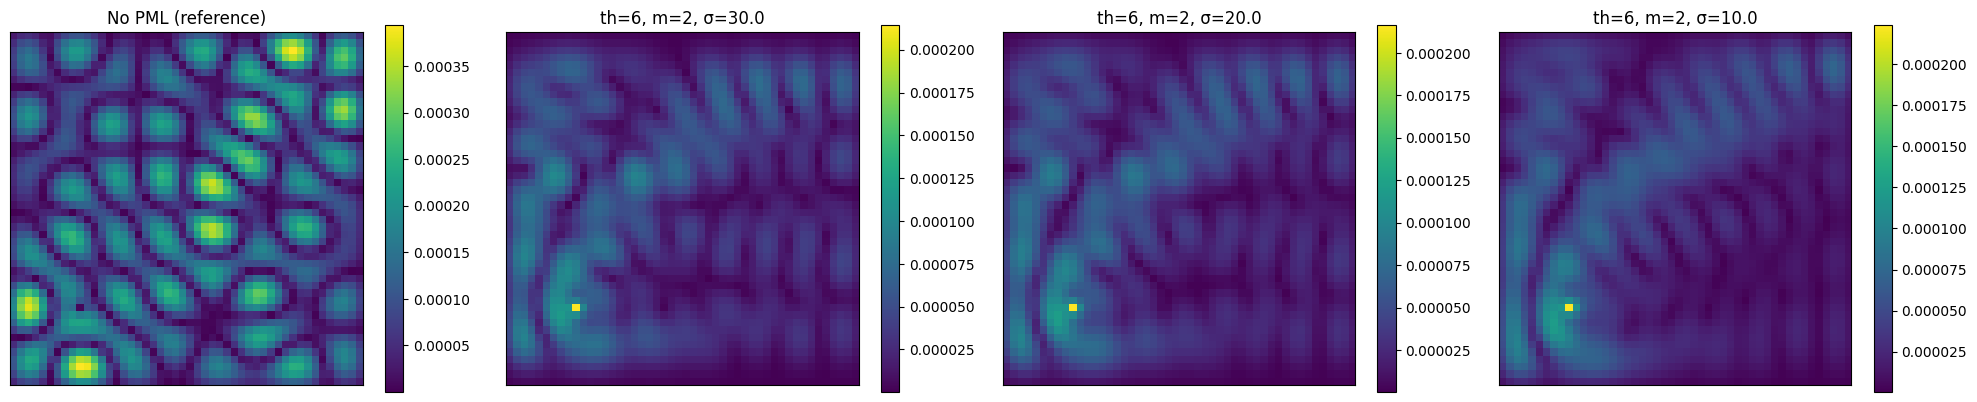

In [23]:
# ---------------------------------------------------------
# 6. Visualize top PML candidates vs reference
# ---------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np

# How many of the top configs to show?
TOP_N = 3

# Take top-N configs from the sorted list
top_configs = tuning_results_sorted[:TOP_N]

# Recompute their solutions (direct solve)
u_candidates = []

for cfg in top_configs:
    pml_cfg = PMLConfig(
        thickness=cfg["thickness"],
        m=cfg["order"],
        sigma_max=cfg["sigma_max"],
    )
    A = assemble_operator(grid=grid, k=k, kind="helmholtz", pml=pml_cfg)
    res = direct_solve(A, b)
    u = res.solution.reshape(grid.shape)
    u_candidates.append((pml_cfg, u))

# ---------------------------------------------------------
# Plot reference + top PML configs side-by-side
# ---------------------------------------------------------

fig, axes = plt.subplots(1, TOP_N + 1, figsize=(5*(TOP_N+1), 4))

# Plot reference
ax = axes[0]
im = ax.imshow(np.abs(u_ref), origin="lower")
ax.set_title("No PML (reference)")
ax.set_xticks([]); ax.set_yticks([])
plt.colorbar(im, ax=ax)

# Plot each top candidate
for ax, (pml_cfg, u) in zip(axes[1:], u_candidates):
    im = ax.imshow(np.abs(u), origin="lower")
    ax.set_title(
        f"th={pml_cfg.thickness}, m={pml_cfg.m}, σ={pml_cfg.sigma_max}"
    )
    ax.set_xticks([]); ax.set_yticks([])
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


# PML Tuning (ω-based, direct solves)

This notebook tunes the PML parameters for the 2D Helmholtz problem:

- We work with *angular frequency* ω and map it to wavenumber k via `omega_to_k`.
- For each PML configuration `(thickness, m, sigma_max)` we:
  - Solve **directly** (no GMRES) for several ω and random RHS seeds.
  - Compare against **no-PML reference solutions**.
  - Measure:
    - `band_ratio`: energy in PML band / interior energy.
    - `interior_loss`: relative change of interior norm vs reference.

We do:
1. Setup grid, ω values, and RHS.
2. Compute reference (no-PML) solutions.
3. Define metrics for a given PML config.
4. Run a **coarse sweep**.
5. Do a **local refinement** around the best coarse configs.
6. Inspect the best configurations.


In [26]:
import numpy as np

from src import (
    GridSpec, PMLConfig,
    assemble_operator,
    RandomPointSource, build_load,
    direct_solve,
)

# 1. Problem setup
grid = GridSpec(dims=2, shape=(48, 48), lengths=(1.0, 1.0))

# Angular frequencies ω to test (you can adjust)
omegas_eval = [20.0, 30.0, 40.0]

# RHS seeds for averaging
rhs_seeds = [123, 456, 789]

print("Grid:", grid)
print("Omega values:", omegas_eval)
print("RHS seeds:", rhs_seeds)

# For now assume c = 1 ⇒ k = ω
def omega_to_k(omega: float) -> float:
    return float(omega)  # change here if c ≠ 1


Grid: GridSpec(dims=2, shape=(48, 48), lengths=(1.0, 1.0))
Omega values: [20.0, 30.0, 40.0]
RHS seeds: [123, 456, 789]


In [27]:
# Precompute RHSs (only depend on the seed, not on ω)
rhs_dict = {}
for seed in rhs_seeds:
    rhs_spec = RandomPointSource(seed=seed)
    rhs = build_load(rhs_spec, grid)  # flattened complex RHS
    rhs_dict[seed] = rhs

print(f"Stored {len(rhs_dict)} right-hand sides.")


Stored 3 right-hand sides.


In [28]:
def pml_band_and_interior_masks(shape, thickness: int):
    """
    Returns two boolean masks (mask_interior, mask_band).

    mask_band: cells within 'thickness' of any boundary
    mask_interior: complement of mask_band
    """
    ny, nx = shape
    band = np.zeros(shape, dtype=bool)

    # top / bottom
    band[:thickness, :] = True
    band[-thickness:, :] = True
    # left / right
    band[:, :thickness] = True
    band[:, -thickness:] = True

    interior = ~band
    return interior, band

# Quick sanity check
mask_int_test, mask_band_test = pml_band_and_interior_masks(grid.shape, thickness=8)
print("Interior cells:", mask_int_test.sum(), "| Band cells:", mask_band_test.sum())


Interior cells: 1024 | Band cells: 1280


In [29]:
# 3. Reference solutions: no PML (direct solves)
# For each (omega, seed) pair, compute u_ref (no PML).
ref_solutions = {}  # key: (omega, seed) -> u_ref (2D array)

for omega in omegas_eval:
    k = omega_to_k(omega)
    A_ref = assemble_operator(grid=grid, k=k, kind="helmholtz", pml=None)
    for seed in rhs_seeds:
        b = rhs_dict[seed]
        res_ref = direct_solve(A_ref, b)
        u_ref = res_ref.solution.reshape(grid.shape)
        ref_solutions[(float(omega), seed)] = u_ref

print("Computed reference (no-PML) solutions for all (omega, seed) pairs.")


Computed reference (no-PML) solutions for all (omega, seed) pairs.


In [30]:
def evaluate_pml_config(thickness: int, sigma_max: float, order: int):
    """
    Evaluate PMLConfig(thickness, order, sigma_max) over all (omega, seed) pairs.
    Returns a dict with averaged metrics:
      - mean_band_ratio      (want this small)
      - mean_interior_loss   (want this small)
    """
    pml_cfg = PMLConfig(thickness=thickness, m=order, sigma_max=sigma_max)
    mask_int, mask_band = pml_band_and_interior_masks(grid.shape, thickness)

    band_ratios = []
    interior_losses = []

    for omega in omegas_eval:
        k = omega_to_k(omega)
        A_pml = assemble_operator(grid=grid, k=k, kind="helmholtz", pml=pml_cfg)

        for seed in rhs_seeds:
            b = rhs_dict[seed]

            # direct solve with PML
            res_pml = direct_solve(A_pml, b)
            u_pml = res_pml.solution.reshape(grid.shape)

            # reference solution for this (omega, seed)
            u_ref = ref_solutions[(float(omega), seed)]

            # norms in interior / band
            int_norm_ref = np.linalg.norm(u_ref[mask_int])
            int_norm     = np.linalg.norm(u_pml[mask_int])
            band_norm    = np.linalg.norm(u_pml[mask_band])

            # metrics
            eps = 1e-15
            band_ratio    = band_norm / (int_norm + eps)                         # PML energy vs interior
            interior_loss = abs(int_norm - int_norm_ref) / (int_norm_ref + eps)  # change in interior

            band_ratios.append(band_ratio)
            interior_losses.append(interior_loss)

    return {
        "thickness": thickness,
        "sigma_max": float(sigma_max),
        "order": order,
        "mean_band_ratio": float(np.mean(band_ratios)),
        "mean_interior_loss": float(np.mean(interior_losses)),
    }

# Quick test on one config
test_res = evaluate_pml_config(thickness=10, sigma_max=20.0, order=3)
print("Test evaluation:", test_res)


Test evaluation: {'thickness': 10, 'sigma_max': 20.0, 'order': 3, 'mean_band_ratio': 1.2514573640998057, 'mean_interior_loss': 0.6601035246911082}


In [31]:
# 5. Coarse sweep
thickness_list_coarse = [6, 10, 14]          # grid cells
sigma_list_coarse     = [5.0, 10.0, 20.0, 30.0]
order_list            = [2, 3]

tuning_results = []
seen = set()  # avoid duplicates

print("Running coarse PML sweep (omega-based)...\n")

for th in thickness_list_coarse:
    for sig in sigma_list_coarse:
        for n in order_list:
            key = (th, sig, n)
            if key in seen:
                continue
            seen.add(key)

            res = evaluate_pml_config(thickness=th, sigma_max=sig, order=n)
            tuning_results.append(res)

            print(
                f"coarse: th={th:2d}, m={n}, sigma={sig:5.1f} | "
                f"band={res['mean_band_ratio']:.2e}, "
                f"loss={res['mean_interior_loss']:.2e}"
            )

# Sort by (band_ratio, interior_loss)
tuning_results_sorted = sorted(
    tuning_results,
    key=lambda r: (r["mean_band_ratio"], r["mean_interior_loss"])
)

print("\nCoarse sweep (sorted best → worst):\n")
for r in tuning_results_sorted:
    print(
        f"th={r['thickness']:2d}, m={r['order']}, sigma={r['sigma_max']:5.1f} | "
        f"band={r['mean_band_ratio']:.2e}, loss={r['mean_interior_loss']:.2e}"
    )


Running coarse PML sweep (omega-based)...

coarse: th= 6, m=2, sigma=  5.0 | band=8.39e-01, loss=6.02e-01
coarse: th= 6, m=3, sigma=  5.0 | band=8.62e-01, loss=5.27e-01
coarse: th= 6, m=2, sigma= 10.0 | band=8.01e-01, loss=6.36e-01
coarse: th= 6, m=3, sigma= 10.0 | band=8.38e-01, loss=6.04e-01
coarse: th= 6, m=2, sigma= 20.0 | band=7.61e-01, loss=6.31e-01
coarse: th= 6, m=3, sigma= 20.0 | band=8.07e-01, loss=6.18e-01
coarse: th= 6, m=2, sigma= 30.0 | band=7.39e-01, loss=6.25e-01
coarse: th= 6, m=3, sigma= 30.0 | band=7.88e-01, loss=6.09e-01
coarse: th=10, m=2, sigma=  5.0 | band=1.31e+00, loss=6.65e-01
coarse: th=10, m=3, sigma=  5.0 | band=1.37e+00, loss=6.49e-01
coarse: th=10, m=2, sigma= 10.0 | band=1.23e+00, loss=6.61e-01
coarse: th=10, m=3, sigma= 10.0 | band=1.32e+00, loss=6.66e-01
coarse: th=10, m=2, sigma= 20.0 | band=1.15e+00, loss=6.45e-01
coarse: th=10, m=3, sigma= 20.0 | band=1.25e+00, loss=6.60e-01
coarse: th=10, m=2, sigma= 30.0 | band=1.11e+00, loss=6.33e-01
coarse: th=1

In [32]:
# 6. Local refinement around the best coarse configs
K_refine = 3   # number of top coarse configs to refine around
centers = tuning_results_sorted[:K_refine]

print("\nStarting local refinement around top coarse configs...\n")

tuning_results_refined = tuning_results.copy()

for c in centers:
    th0  = c["thickness"]
    sig0 = c["sigma_max"]
    n0   = c["order"]

    # thickness neighborhood (±2 cells, inside [2, min(shape)/2])
    th_candidates = [
        th for th in range(th0 - 2, th0 + 3)
        if 2 <= th <= min(grid.shape) // 2
    ]

    # sigma neighborhood (±50% around current value)
    sig_candidates = np.linspace(0.5 * sig0, 1.5 * sig0, 5)

    for th in th_candidates:
        for sig in sig_candidates:
            key = (th, float(sig), n0)
            if key in seen:
                continue
            seen.add(key)

            res = evaluate_pml_config(thickness=th, sigma_max=float(sig), order=n0)
            tuning_results_refined.append(res)

            print(
                f"refine around (th0={th0}, sigma0={sig0:.1f}, m0={n0}): "
                f"th={th:2d}, m={n0}, sigma={sig:6.2f} | "
                f"band={res['mean_band_ratio']:.2e}, "
                f"loss={res['mean_interior_loss']:.2e}"
            )

# Final sort
tuning_results_final = sorted(
    tuning_results_refined,
    key=lambda r: (r["mean_band_ratio"], r["mean_interior_loss"])
)

print("\nFinal PML tuning results (best 20):\n")
for r in tuning_results_final[:20]:
    print(
        f"th={r['thickness']:2d}, m={r['order']}, sigma={r['sigma_max']:6.2f} | "
        f"band={r['mean_band_ratio']:.2e}, loss={r['mean_interior_loss']:.2e}"
    )

best = tuning_results_final[0]
print("\n>>> Recommended PML (from omega-based refined tuning run):")
print(best)



Starting local refinement around top coarse configs...

refine around (th0=6, sigma0=30.0, m0=2): th= 4, m=2, sigma= 15.00 | band=5.73e-01, loss=5.72e-01
refine around (th0=6, sigma0=30.0, m0=2): th= 4, m=2, sigma= 22.50 | band=5.57e-01, loss=5.76e-01
refine around (th0=6, sigma0=30.0, m0=2): th= 4, m=2, sigma= 30.00 | band=5.45e-01, loss=5.67e-01
refine around (th0=6, sigma0=30.0, m0=2): th= 4, m=2, sigma= 37.50 | band=5.35e-01, loss=5.52e-01
refine around (th0=6, sigma0=30.0, m0=2): th= 4, m=2, sigma= 45.00 | band=5.28e-01, loss=5.37e-01
refine around (th0=6, sigma0=30.0, m0=2): th= 5, m=2, sigma= 15.00 | band=6.74e-01, loss=6.13e-01
refine around (th0=6, sigma0=30.0, m0=2): th= 5, m=2, sigma= 22.50 | band=6.55e-01, loss=6.04e-01
refine around (th0=6, sigma0=30.0, m0=2): th= 5, m=2, sigma= 30.00 | band=6.41e-01, loss=5.91e-01
refine around (th0=6, sigma0=30.0, m0=2): th= 5, m=2, sigma= 37.50 | band=6.31e-01, loss=5.77e-01
refine around (th0=6, sigma0=30.0, m0=2): th= 5, m=2, sigma= 

## Next steps

- Fix the recommended `PMLConfig` from the tuning run and use it in all
  subsequent experiments.
- Optionally:
  - Visualize `|u|` for the best 1–3 PML configs against the no-PML reference.
  - Add a short paragraph in the thesis describing:
    - the ranges used for `(thickness, m, sigma_max)`,
    - the metrics (`mean_band_ratio`, `mean_interior_loss`),
    - and the final chosen configuration.


Best PML configuration:
  thickness = 4
  order     = 2
  sigma_max = 45.000
  mean_band_ratio   = 5.28e-01
  mean_interior_loss = 5.37e-01

Visualizing for omega = 30.0, seed = 123


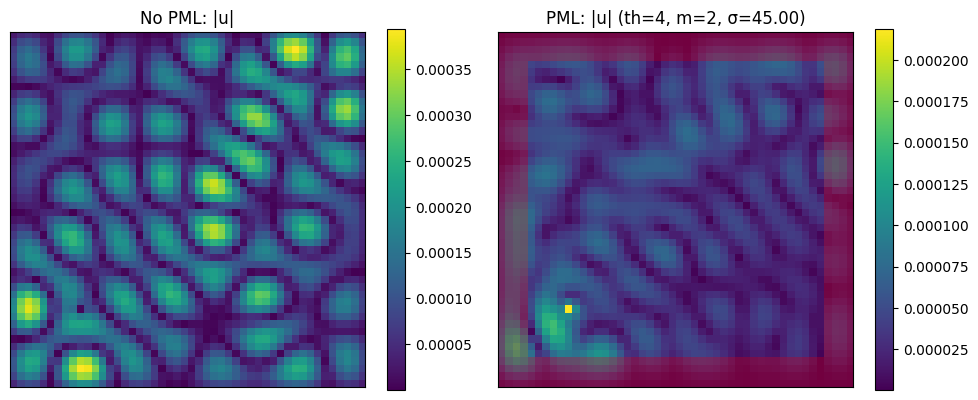

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------
# Visualization of best PML vs no-PML reference
# ---------------------------------------------------------

# 1. Take the best config from tuning_results_final
best = tuning_results_final[0]
th_best  = best["thickness"]
sig_best = best["sigma_max"]
m_best   = best["order"]

pml_best = PMLConfig(thickness=th_best, m=m_best, sigma_max=sig_best)

print("Best PML configuration:")
print(f"  thickness = {th_best}")
print(f"  order     = {m_best}")
print(f"  sigma_max = {sig_best:.3f}")
print(f"  mean_band_ratio   = {best['mean_band_ratio']:.2e}")
print(f"  mean_interior_loss = {best['mean_interior_loss']:.2e}")

# 2. Choose a representative (omega, seed) to visualize
omega_vis = omegas_eval[len(omegas_eval) // 2]  # middle omega
seed_vis  = rhs_seeds[0]                        # first seed

print(f"\nVisualizing for omega = {omega_vis}, seed = {seed_vis}")

# 3. Get RHS and reference solution (no PML)
k_vis = omega_to_k(omega_vis)
b_vis = rhs_dict[seed_vis]
u_ref = ref_solutions[(float(omega_vis), seed_vis)]

# 4. Solve with best PML (direct solve for clean comparison)
A_pml_vis = assemble_operator(grid=grid, k=k_vis, kind="helmholtz", pml=pml_best)
res_pml_vis = direct_solve(A_pml_vis, b_vis)
u_pml = res_pml_vis.solution.reshape(grid.shape)

# 5. Build PML band mask to overlay
mask_int, mask_band = pml_band_and_interior_masks(grid.shape, th_best)

# 6. Plot |u| side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# No-PML reference
ax = axes[0]
im0 = ax.imshow(np.abs(u_ref), origin="lower")
ax.set_title("No PML: |u|")
ax.set_xticks([]); ax.set_yticks([])
plt.colorbar(im0, ax=ax)

# PML solution
ax = axes[1]
im1 = ax.imshow(np.abs(u_pml), origin="lower")
ax.set_title(f"PML: |u| (th={th_best}, m={m_best}, σ={sig_best:.2f})")
ax.set_xticks([]); ax.set_yticks([])
plt.colorbar(im1, ax=ax)

# Optional: overlay PML band as semi-transparent mask on the PML plot
overlay = np.zeros((*grid.shape, 4), dtype=float)  # RGBA
overlay[..., 0] = 1.0      # red
overlay[..., 3] = 0.25*mask_band  # alpha only where band=True
ax.imshow(overlay, origin="lower")

plt.tight_layout()
plt.show()


According to theory

In [34]:
import numpy as np

# --- 1. Pick theoretical design choices ---

omega_max = max(omegas_eval)

c = 1.0                     # wave speed (change if needed)
lambda_min = 2 * np.pi * c / omega_max   # smallest wavelength

# Thickness: about 1 wavelength at the highest frequency
delta_pml_wavelengths = 1.0
delta_pml_phys = delta_pml_wavelengths * lambda_min

h = grid.spacing[0]         # assume uniform grid
th_fixed = int(round(delta_pml_phys / h))
th_fixed = max(th_fixed, 8) # safety lower bound

# Ramp exponent m: fix it (no optimization)
m_fixed = 2

# Target amplitude reduction inside the PML at omega_max
R_target = 1e-3   # |u| reduced to 1e-3 at outer edge of PML

# From theory: sigma_max ≈ -(m+1)*ω_max/δ_pml * log R
sigma_baseline = - (m_fixed + 1) * omega_max / delta_pml_phys * np.log(R_target)

print(f"omega_max       = {omega_max:.2f}")
print(f"lambda_min      = {lambda_min:.3f}")
print(f"grid spacing h  = {h:.3f}")
print(f"thickness_fixed = {th_fixed} cells (~{th_fixed*h:.3f} m)")
print(f"m_fixed         = {m_fixed}")
print(f"sigma_baseline  = {sigma_baseline:.2f}")



omega_max       = 40.00
lambda_min      = 0.157
grid spacing h  = 0.021
thickness_fixed = 8 cells (~0.170 m)
m_fixed         = 2
sigma_baseline  = 5277.14


In [35]:
def evaluate_sigma(sigma_max: float):
    """
    Evaluate a PML with:
      thickness = th_fixed,
      order     = m_fixed,
      sigma_max = sigma_max
    over all (omega, seed) pairs.

    Returns metrics:
      - mean_band_ratio
      - mean_interior_loss
    """
    pml_cfg = PMLConfig(thickness=th_fixed, m=m_fixed, sigma_max=float(sigma_max))
    mask_int, mask_band = pml_band_and_interior_masks(grid.shape, th_fixed)

    band_ratios = []
    interior_losses = []

    for omega in omegas_eval:
        k = omega_to_k(omega)
        A_pml = assemble_operator(grid=grid, k=k, kind="helmholtz", pml=pml_cfg)

        for seed in rhs_seeds:
            b = rhs_dict[seed]

            # direct solve with PML
            res_pml = direct_solve(A_pml, b)
            u_pml = res_pml.solution.reshape(grid.shape)

            # reference solution for this (omega, seed) with *same* interior mask
            u_ref = ref_solutions[(float(omega), seed)]

            int_norm_ref = np.linalg.norm(u_ref[mask_int])
            int_norm     = np.linalg.norm(u_pml[mask_int])
            band_norm    = np.linalg.norm(u_pml[mask_band])

            eps = 1e-15
            band_ratio    = band_norm / (int_norm + eps)
            interior_loss = abs(int_norm - int_norm_ref) / (int_norm_ref + eps)

            band_ratios.append(band_ratio)
            interior_losses.append(interior_loss)

    return {
        "thickness": th_fixed,
        "order": m_fixed,
        "sigma_max": float(sigma_max),
        "mean_band_ratio": float(np.mean(band_ratios)),
        "mean_interior_loss": float(np.mean(interior_losses)),
    }

# Quick sanity check at baseline sigma
test = evaluate_sigma(sigma_baseline)
print("Baseline sigma metrics:", test)


Baseline sigma metrics: {'thickness': 8, 'order': 2, 'sigma_max': 5277.136311931879, 'mean_band_ratio': 6.229378714925284, 'mean_interior_loss': 0.6511528338650177}


In [36]:
# --- 3. Constrained sweep around theoretical sigma_baseline ---

# Explore a small neighborhood around the theoretical value
sigma_factors = [0.5, 0.75, 1.0, 1.25, 1.5]
sigma_candidates = [sigma_baseline * f for f in sigma_factors]

interior_loss_max = 0.2  # HARD constraint: interior change must be < 20%

results_sigma = []

print("Sweeping sigma around theoretical baseline...\n")

for sig in sigma_candidates:
    res = evaluate_sigma(sig)
    results_sigma.append(res)
    print(
        f"sigma={sig:7.2f} | "
        f"band={res['mean_band_ratio']:.2e}, "
        f"loss={res['mean_interior_loss']:.2e}"
    )

# Filter by interior-loss constraint
feasible = [r for r in results_sigma if r["mean_interior_loss"] < interior_loss_max]

if not feasible:
    print("\nWARNING: No sigma satisfies the interior_loss constraint; "
          "consider relaxing the threshold or adjusting thickness/R_target.")
else:
    # Among feasible, choose smallest band_ratio
    feasible_sorted = sorted(feasible,
                             key=lambda r: r["mean_band_ratio"])
    best = feasible_sorted[0]

    print("\n>>> Recommended PML config (theory-guided + constrained):")
    print(
        f"thickness = {best['thickness']} cells\n"
        f"order     = {best['order']}\n"
        f"sigma_max = {best['sigma_max']:.2f}\n"
        f"mean_band_ratio   = {best['mean_band_ratio']:.2e}\n"
        f"mean_interior_loss = {best['mean_interior_loss']:.2e}"
    )

    # You can now use:
    # pml_final = PMLConfig(thickness=best['thickness'],
    #                       m=best['order'],
    #                       sigma_max=best['sigma_max'])


Sweeping sigma around theoretical baseline...

sigma=2638.57 | band=2.04e+00, loss=4.97e-01
sigma=3957.85 | band=3.90e+00, loss=5.00e-01
sigma=5277.14 | band=6.23e+00, loss=6.51e-01
sigma=6596.42 | band=9.09e+00, loss=7.72e-01
sigma=7915.70 | band=1.34e+01, loss=7.09e-01

